In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from models.BetaVAE import Lit_BetaVAE
from models.MKMMD_VAE import Lit_MKMMD_VAE
from models.InfoVAE import Lit_InfoVAE
from helpers.PhotonsDataModule import PhotonsDataModule
from helpers.plot_helper import get_subplot_adjustment

In [5]:
LOAD_CHECKPOINT_PATH='/home/jakmic/Projekty/dose3d-phsp/AE_VAE/Lightning_Autoencoders/results/InfoVAE/version_13/checkpoints/last.ckpt'#'/home/jakmic/Projekty/dose3d-phsp/AE_VAE/Lightning_Autoencoders/results/MKMMD_VAE/version_7/last.ckpt'
DATA_PATH='/data1/dose-3d-generative/data/training-data/PHSPs_without_VR/Filtered_E5.6_s0.0.npy'
BATCH_SIZE=300000
NUM_WORKERS=0
TEST_FRACTION=0.0
VALIDATION_FRACTION = 0.4
SHUFFLE_TRAIN=False
RANDOM_SEED=123



LANTENT_SPACE_DIM=12
NUM_SUBPLOT_ROWS, NUM_SUBPLOT_COLUMNS = get_subplot_adjustment(LANTENT_SPACE_DIM)
print(NUM_SUBPLOT_ROWS, NUM_SUBPLOT_COLUMNS)

3 4


In [6]:
dm=PhotonsDataModule(data_path=DATA_PATH,batch_size=BATCH_SIZE, num_workers=NUM_WORKERS,test_fraction=TEST_FRACTION,validation_fraction=VALIDATION_FRACTION,shuffle_train=SHUFFLE_TRAIN,random_seed=RANDOM_SEED)
model=Lit_InfoVAE.load_from_checkpoint(LOAD_CHECKPOINT_PATH)
dm.setup()

In [7]:
decoded=np.empty((0,6))
encoded=np.empty((0,LANTENT_SPACE_DIM))
orginal_photons=np.empty((0,6))
generated=np.empty((0,6))
noise=np.empty((0,LANTENT_SPACE_DIM))

model.eval()
with torch.no_grad():
    for photon_batch in dm.val_dataloader():
        # Generate noise batch from normal distribution
        noise_batch=torch.randn(size=(photon_batch.size(0),LANTENT_SPACE_DIM))

        # Encode and Encode+Decode orginal photons from val_loader
        encoded_batch, _, _, decoded_batch = model(photon_batch)
        # Decode noise batch
        generated_batch = model.decoder(noise_batch)

        encoded_batch=encoded_batch.cpu().detach().numpy()
        decoded_batch=decoded_batch.cpu().detach().numpy()
        photon_batch=photon_batch.cpu().detach().numpy()
        generated_batch=generated_batch.cpu().detach().numpy()
        noise_batch=noise_batch.cpu().detach().numpy()
        
        # Standarizer inverse transform
        decoded_batch=dm.stdcs.inverse_transform(decoded_batch)
        photon_batch=dm.stdcs.inverse_transform(photon_batch)
        generated_batch=dm.stdcs.inverse_transform(generated_batch)

        # Prepare numpy arrays
        noise = np.append(noise, noise_batch, axis=0)
        generated = np.append(generated, generated_batch,axis=0)
        orginal_photons = np.append(orginal_photons,photon_batch, axis=0)
        decoded = np.append(decoded, decoded_batch,axis=0)
        encoded= np.append(encoded, encoded_batch, axis=0)

        print(decoded.shape)

(300000, 6)
(600000, 6)
(900000, 6)
(1200000, 6)
(1500000, 6)
(1800000, 6)
(2100000, 6)
(2400000, 6)
(2700000, 6)
(3000000, 6)
(3300000, 6)
(3600000, 6)
(3900000, 6)
(4200000, 6)
(4500000, 6)
(4800000, 6)
(5087614, 6)


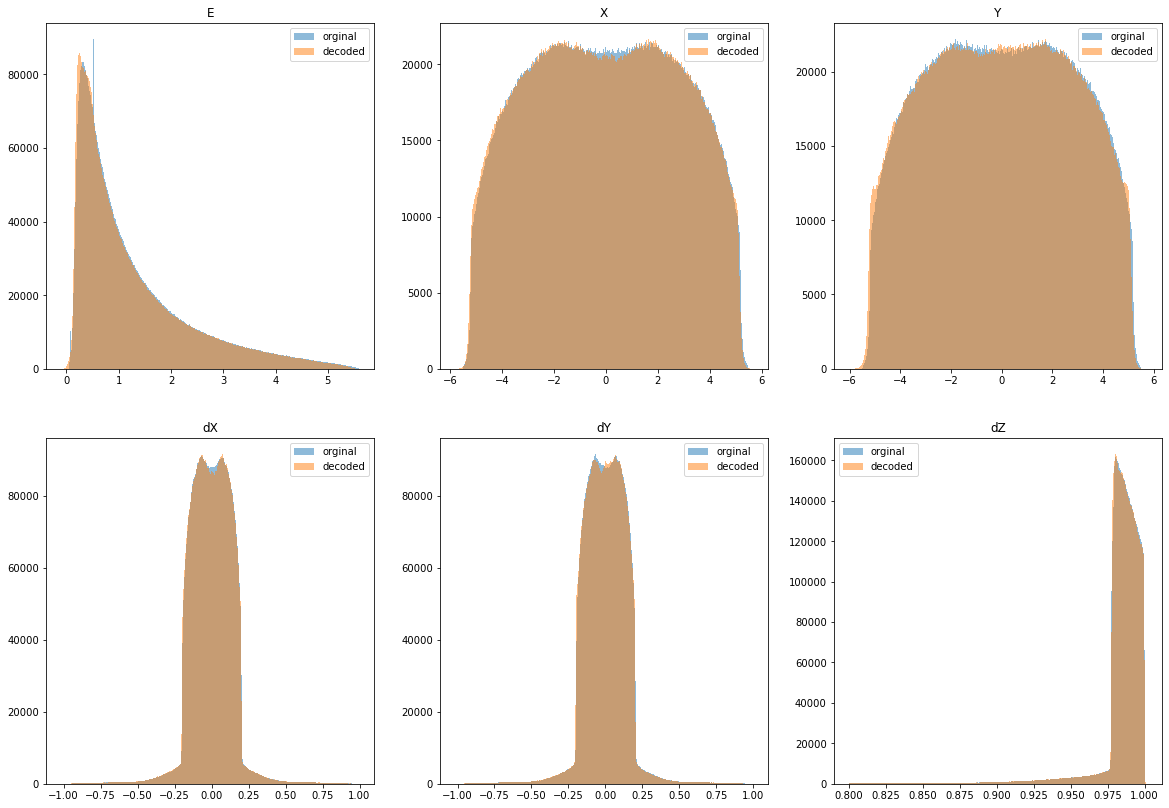

In [8]:
keys = ['E','X', 'Y', 'dX', 'dY', 'dZ']
fig, axs = plt.subplots(2, 3)
fig.set_size_inches(20, 14)
for i, j in enumerate(keys):
    mi = np.minimum(orginal_photons[:, i].min(), decoded[:, i].min())
    ma = np.maximum(orginal_photons[:, i].max(), decoded[:, i].max())
    if j=='dZ':
        mi=0.8
    bins = np.linspace(mi, ma, 300)
    axs.flatten()[i].hist(orginal_photons[:, i], bins, alpha=.5, label='orginal')
    axs.flatten()[i].hist(decoded[:, i], bins, alpha=.5, label='decoded')
    axs.flatten()[i].set_title(j)
    axs.flatten()[i].legend()

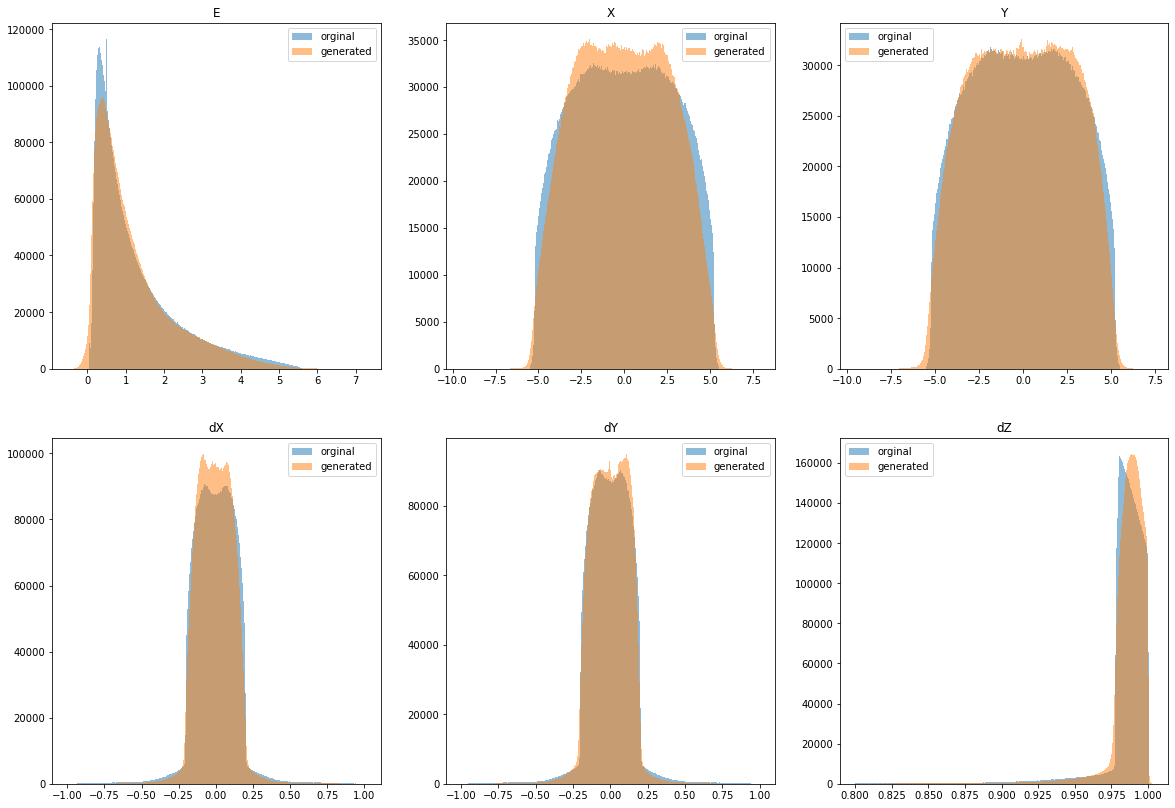

In [9]:
fig, axs = plt.subplots(2, 3)
fig.set_size_inches(20, 14)
for i, j in enumerate(keys):
    mi = np.minimum(orginal_photons[:, i].min(), generated[:, i].min())
    ma = np.maximum(orginal_photons[:, i].max(), generated[:, i].max())
    if j=='dZ':
        mi=0.8
    bins = np.linspace(mi, ma, 300)
    axs.flatten()[i].hist(orginal_photons[:, i], bins, alpha=.5, label='orginal')
    axs.flatten()[i].hist(generated[:, i], bins, alpha=.5, label='generated')
    axs.flatten()[i].set_title(j)
    axs.flatten()[i].legend()

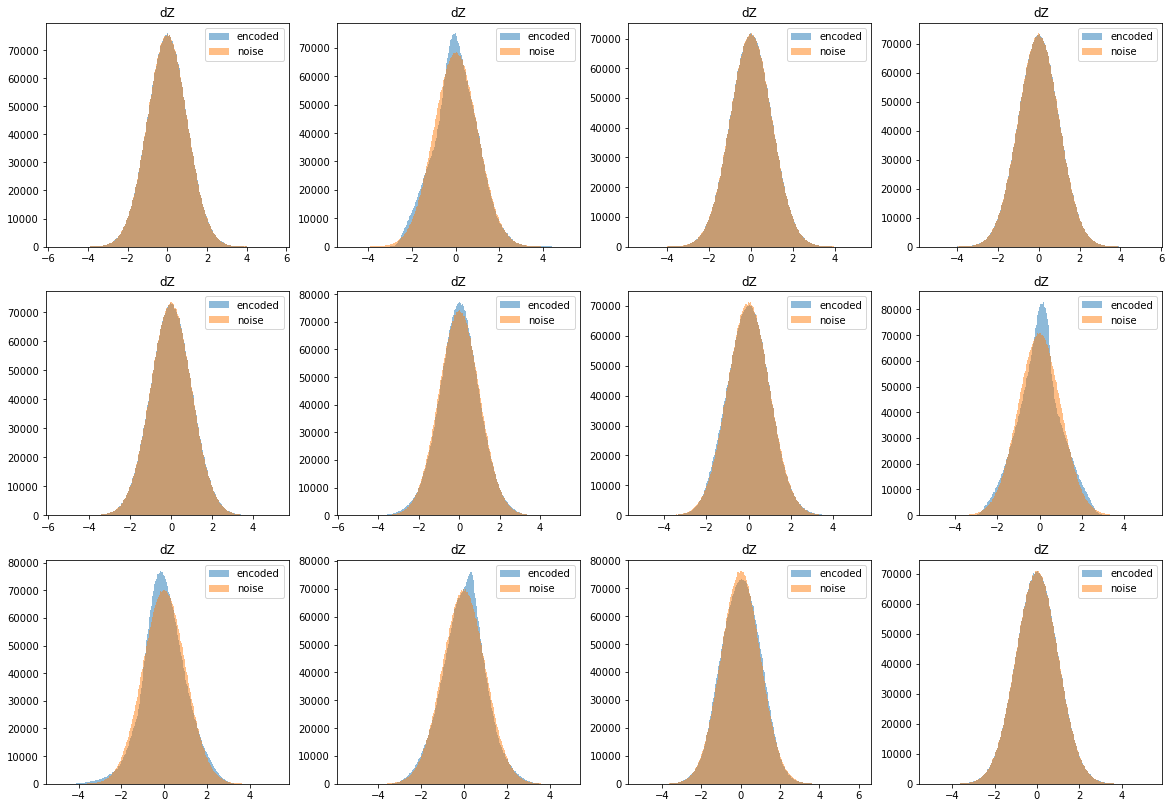

In [10]:
fig, axs = plt.subplots(NUM_SUBPLOT_ROWS, NUM_SUBPLOT_COLUMNS)
fig.set_size_inches(20, 14)
for i in range(LANTENT_SPACE_DIM):
    mi = np.minimum(encoded[:, i].min(), noise[:, i].min())
    ma = np.maximum(encoded[:, i].max(), noise[:, i].max())
    bins = np.linspace(mi, ma, 300)
    axs.flatten()[i].hist(encoded[:, i], bins, alpha=.5, label='encoded')
    axs.flatten()[i].hist(noise[:, i], bins, alpha=.5, label='noise')
    axs.flatten()[i].set_title(j)
    axs.flatten()[i].legend()

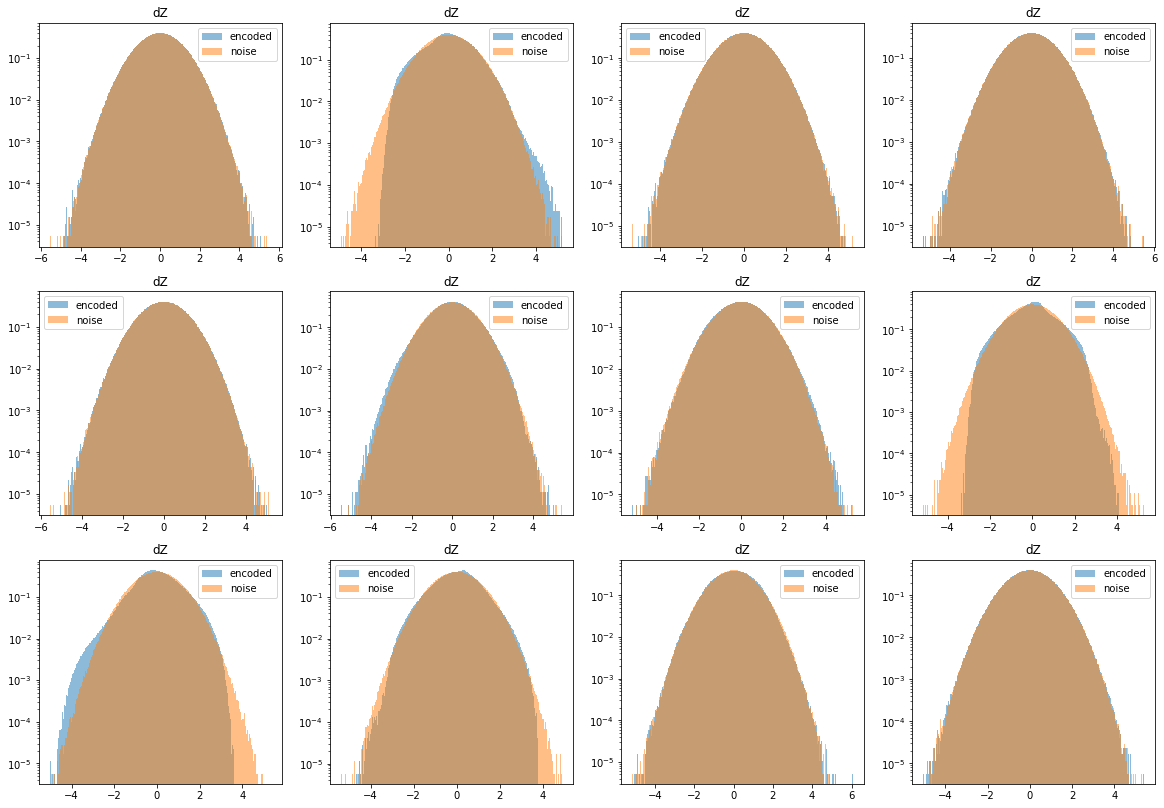

In [11]:
fig, axs = plt.subplots(NUM_SUBPLOT_ROWS, NUM_SUBPLOT_COLUMNS)
fig.set_size_inches(20, 14)
for i in range(LANTENT_SPACE_DIM):
    mi = np.minimum(encoded[:, i].min(), noise[:, i].min())
    ma = np.maximum(encoded[:, i].max(), noise[:, i].max())
    bins = np.linspace(mi, ma, 300)
    axs.flatten()[i].hist(encoded[:, i], bins, alpha=.5, label='encoded', density=True, stacked=True, log=True)
    axs.flatten()[i].hist(noise[:, i], bins, alpha=.5, label='noise', density=True, stacked=True, log=True)
    axs.flatten()[i].set_title(j)
    axs.flatten()[i].legend()

[[ 1.00000000e+00 -1.09710836e-03 -1.57291724e-04 -2.76881343e-05
  -2.16107004e-04 -3.26733900e-04 -2.32361916e-03 -5.22163937e-03
   1.37495522e-03 -1.86784609e-03 -1.88072698e-03 -5.24843209e-04]
 [-1.09710836e-03  1.00000000e+00 -2.60691673e-03 -2.69304895e-03
  -1.18102460e-03  1.17837539e-02 -5.15919777e-03  1.80528827e-02
   5.22335546e-03 -1.28255930e-02  1.21329538e-04  2.68116634e-03]
 [-1.57291724e-04 -2.60691673e-03  1.00000000e+00  2.00145511e-04
   3.06082719e-04 -1.43895827e-03 -1.92733614e-04 -6.71063425e-03
   3.18745271e-03  2.95195417e-03  8.66252423e-04 -9.32959075e-04]
 [-2.76881343e-05 -2.69304895e-03  2.00145511e-04  1.00000000e+00
  -3.74251781e-05 -2.03802903e-03  9.97394931e-04  1.01816475e-03
   2.64453657e-04  2.43176691e-04  5.19279637e-04 -9.95417833e-04]
 [-2.16107004e-04 -1.18102460e-03  3.06082719e-04 -3.74251781e-05
   1.00000000e+00 -2.26824988e-04 -3.42078097e-04  2.37606415e-03
   5.98081346e-05  1.27122930e-03 -1.01729875e-04  8.61492607e-04]
 [-3.

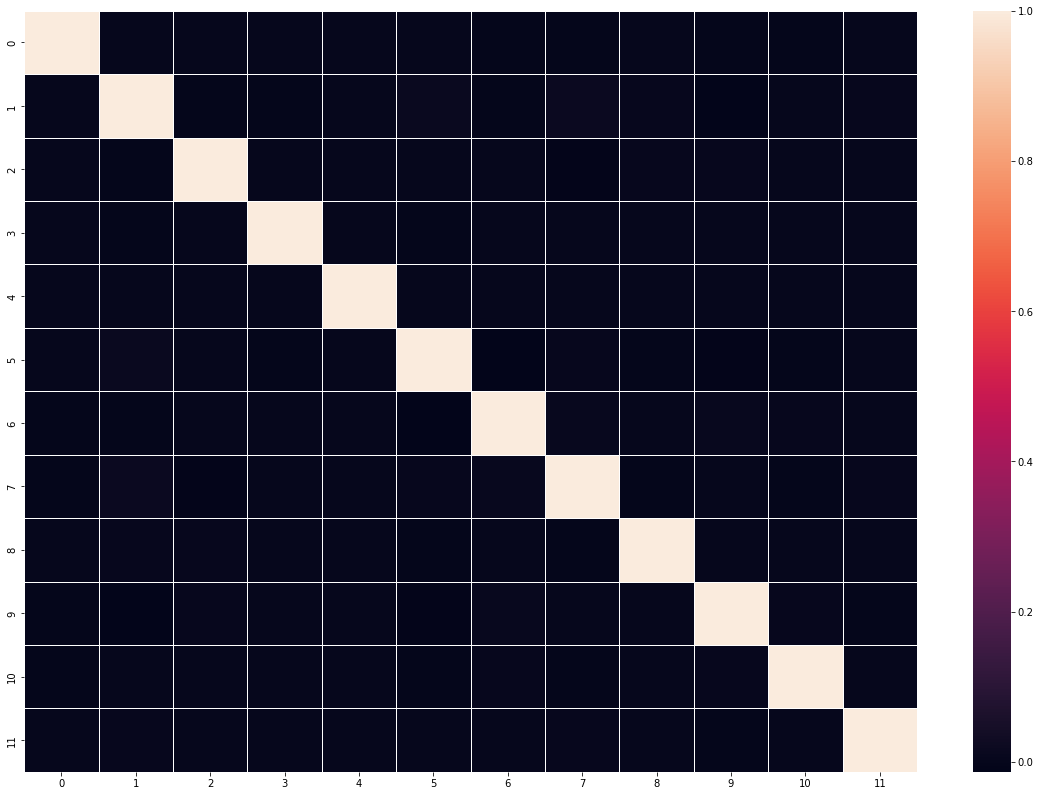

In [12]:
corr = np.corrcoef(np.transpose(encoded))
print(corr)
fig, ax = plt.subplots(figsize=(20,14))
sns.heatmap(corr, linewidth=0.5,ax=ax)
plt.show()

In [13]:
from sklearn.decomposition import PCA

pca = PCA(n_components=LANTENT_SPACE_DIM,svd_solver = 'full')
pca.fit(encoded)
print(np.sum(pca.explained_variance_ratio_))
pca_encoded= pca.transform(encoded)
pca_noise=pca.transform(noise)

0.9999999999999999


[[ 1.00000000e+00 -2.09193475e-16  4.11654139e-16  3.77679269e-16
  -2.82203963e-16  7.17632070e-16  5.46726935e-16 -4.08402421e-16
   2.78688811e-16 -1.08897091e-15 -2.34214390e-17  3.63305526e-16]
 [-2.09193475e-16  1.00000000e+00  4.23574550e-16  1.09074597e-16
  -1.21512549e-16 -3.06592133e-16  1.24387082e-16  1.27342535e-16
  -2.88764764e-16 -8.69572282e-16 -4.16436440e-16  2.83101723e-16]
 [ 4.11654139e-16  4.23574550e-16  1.00000000e+00  3.12559350e-16
  -5.61793230e-16  1.30773026e-16  1.36693469e-16  3.19947992e-16
   4.46090988e-17 -1.12583398e-16 -1.92946911e-16  2.85228393e-16]
 [ 3.77679269e-16  1.09074597e-16  3.12559350e-16  1.00000000e+00
  -2.25476160e-15  8.11571393e-16  2.97220340e-16  6.09641027e-17
  -1.85225221e-16  9.78944735e-16  6.41034219e-16  5.22717545e-16]
 [-2.82203963e-16 -1.21512549e-16 -5.61793230e-16 -2.25476160e-15
   1.00000000e+00 -8.17844717e-16 -1.02510870e-15 -6.43795313e-16
  -3.46513177e-16 -1.02298325e-16 -6.09448966e-16 -7.72113874e-16]
 [ 7.

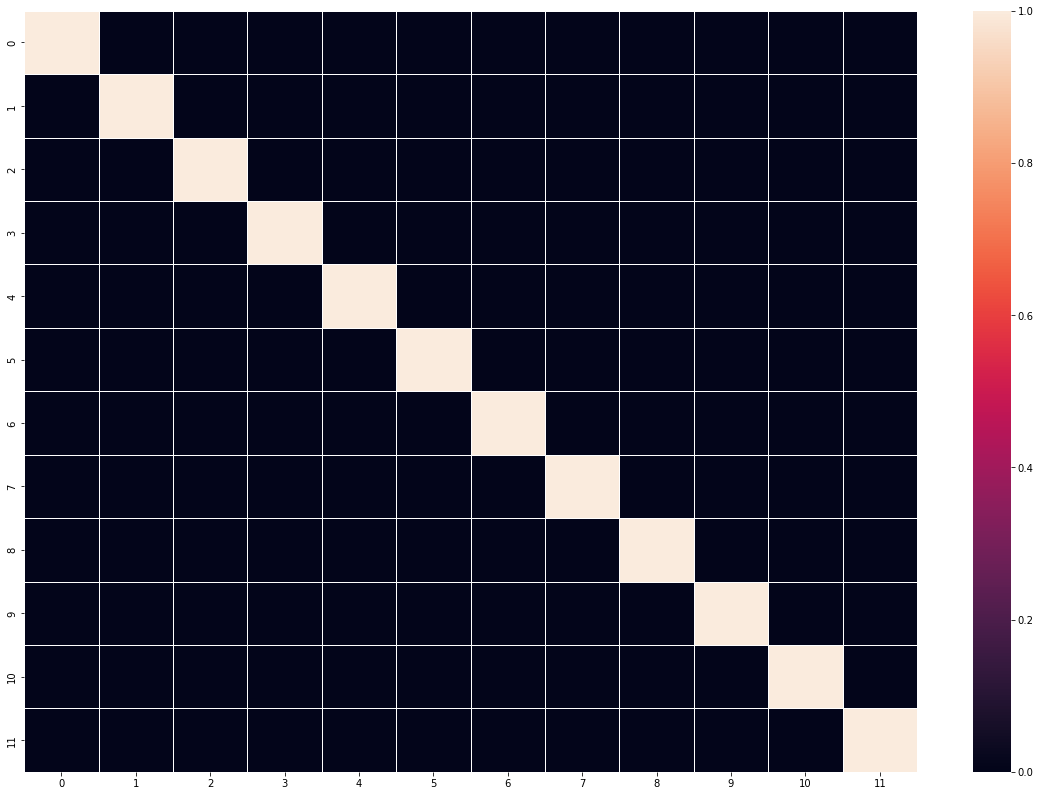

In [14]:
pca_corr = np.corrcoef(np.transpose(pca_encoded))
print(pca_corr)

fig, ax = plt.subplots(figsize=(20,14))
sns.heatmap(pca_corr, linewidth=0.5,ax=ax)
plt.show()

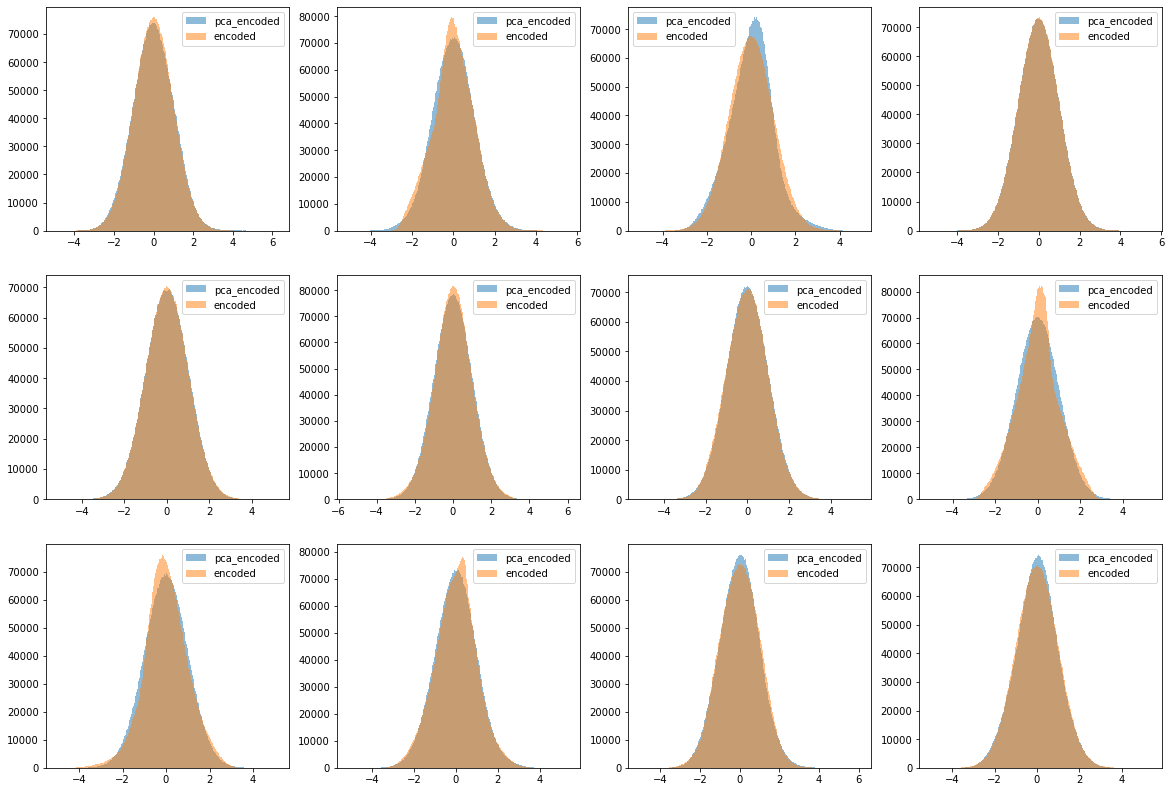

In [15]:
fig, axs = plt.subplots(NUM_SUBPLOT_ROWS, NUM_SUBPLOT_COLUMNS)
fig.set_size_inches(20, 14)
for i in range(LANTENT_SPACE_DIM):
    mi = np.minimum(pca_encoded[:, i].min(), encoded[:, i].min())
    ma = np.maximum(pca_encoded[:, i].max(), encoded[:, i].max())
    bins = np.linspace(mi, ma, 300)
    axs.flatten()[i].hist(pca_encoded[:, i], bins, alpha=.5, label='pca_encoded')
    axs.flatten()[i].hist(encoded[:, i], bins, alpha=.5, label='encoded')
    # axs.flatten()[i].set_title(j)
    axs.flatten()[i].legend()

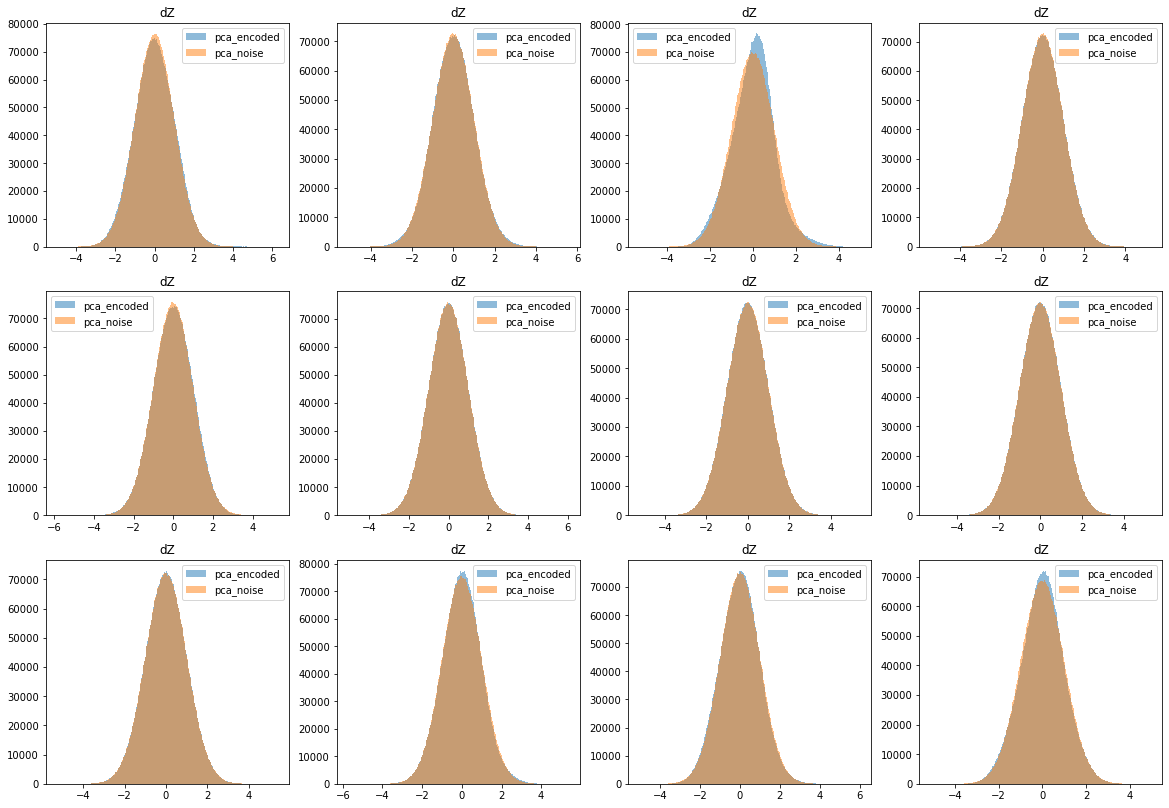

In [16]:
fig, axs = plt.subplots(NUM_SUBPLOT_ROWS, NUM_SUBPLOT_COLUMNS)
fig.set_size_inches(20, 14)
for i in range(LANTENT_SPACE_DIM):
    mi = np.minimum(pca_encoded[:, i].min(), pca_noise[:, i].min())
    ma = np.maximum(pca_encoded[:, i].max(), pca_noise[:, i].max())
    bins = np.linspace(mi, ma, 300)
    axs.flatten()[i].hist(pca_encoded[:, i], bins, alpha=.5, label='pca_encoded')
    axs.flatten()[i].hist(pca_noise[:, i], bins, alpha=.5, label='pca_noise')
    axs.flatten()[i].set_title(j)
    axs.flatten()[i].legend()

In [17]:
from helpers.data_helper import PhotonsDataset, ToTensorFromNdarray
from torch.utils.data import DataLoader

pca_encoded_dataset = PhotonsDataset(data=pca_encoded, transform=ToTensorFromNdarray())
pca_encoded_dataloader=DataLoader(dataset=pca_encoded_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)
pca_noise_dataset=PhotonsDataset(data=pca_noise, transform=ToTensorFromNdarray())
pca_noise_dataloader=DataLoader(dataset=pca_noise_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

In [18]:
pca_decoded=np.empty((0,6))


model.eval()
with torch.no_grad():
    for pca_encoded_batch in pca_encoded_dataloader:

        # Decode pca_encode_batch
        pca_decoded_batch = model.decoder(pca_encoded_batch.float())

        pca_decoded_batch=pca_decoded_batch.cpu().detach().numpy()
        
        # Standarizer inverse transform
        pca_decoded_batch=dm.stdcs.inverse_transform(pca_decoded_batch)

        # Prepare numpy arrays
        pca_decoded = np.append(pca_decoded, pca_decoded_batch, axis=0)

        print(pca_decoded.shape)

(300000, 6)
(600000, 6)
(900000, 6)
(1200000, 6)
(1500000, 6)
(1800000, 6)
(2100000, 6)
(2400000, 6)
(2700000, 6)
(3000000, 6)
(3300000, 6)
(3600000, 6)
(3900000, 6)
(4200000, 6)
(4500000, 6)
(4800000, 6)
(5087614, 6)


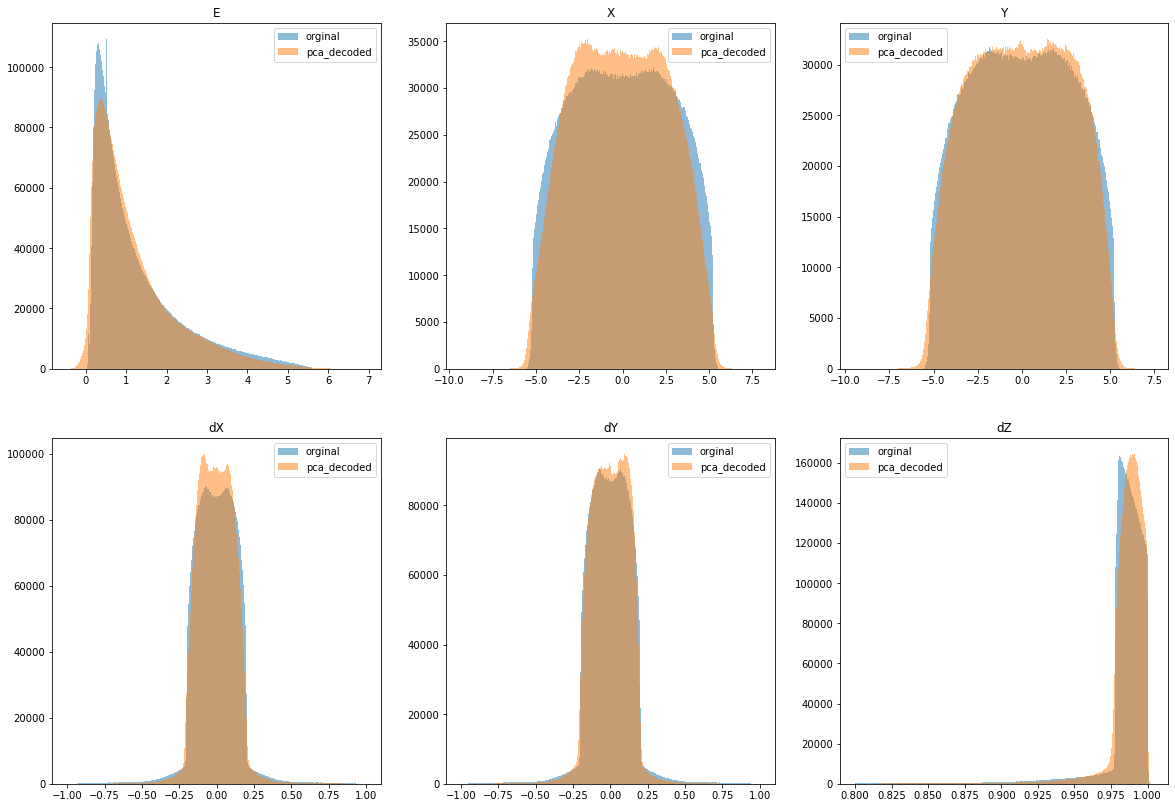

In [19]:
fig, axs = plt.subplots(2, 3)
fig.set_size_inches(20, 14)
for i, j in enumerate(keys):
    mi = np.minimum(orginal_photons[:, i].min(), pca_decoded[:, i].min())
    ma = np.maximum(orginal_photons[:, i].max(), pca_decoded[:, i].max())
    if j=='dZ':
        mi=0.8
    bins = np.linspace(mi, ma, 300)
    axs.flatten()[i].hist(orginal_photons[:, i], bins, alpha=.5, label='orginal')
    axs.flatten()[i].hist(pca_decoded[:, i], bins, alpha=.5, label='pca_decoded')
    axs.flatten()[i].set_title(j)
    axs.flatten()[i].legend()

In [20]:
pca_generated=np.empty((0,6))
model.eval()
with torch.no_grad():
    for pca_noise_batch in pca_noise_dataloader:

        # Decode pca_encode_batch
        pca_generated_batch = model.decoder(pca_noise_batch.float())

        pca_generated_batch=pca_generated_batch.cpu().detach().numpy()
        
        # Standarizer inverse transform
        pca_generated_batch=dm.stdcs.inverse_transform(pca_generated_batch)

        # Prepare numpy arrays
        pca_generated = np.append(pca_generated, pca_generated_batch, axis=0)

        print(pca_generated.shape)

(300000, 6)


: 

: 

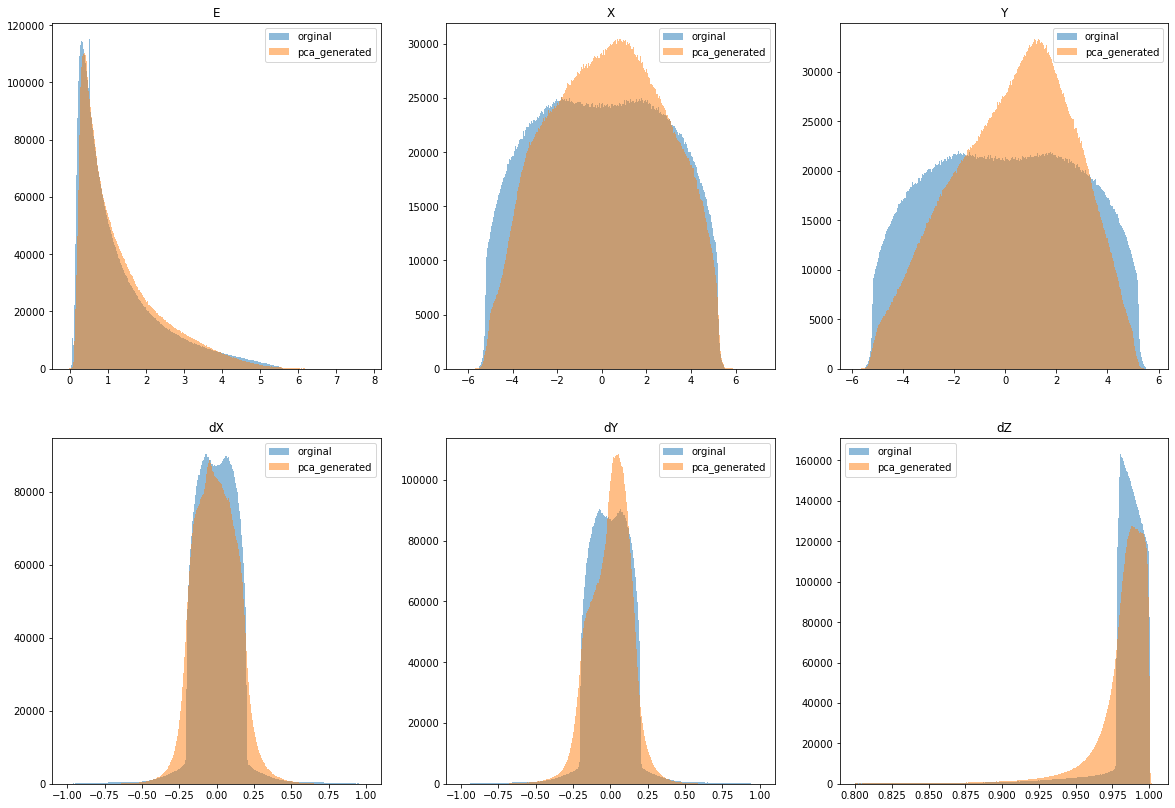

In [ ]:
fig, axs = plt.subplots(2, 3)
fig.set_size_inches(20, 14)
for i, j in enumerate(keys):
    mi = np.minimum(orginal_photons[:, i].min(), pca_generated[:, i].min())
    ma = np.maximum(orginal_photons[:, i].max(), pca_generated[:, i].max())
    if j=='dZ':
        mi=0.8
    bins = np.linspace(mi, ma, 300)
    axs.flatten()[i].hist(orginal_photons[:, i], bins, alpha=.5, label='orginal')
    axs.flatten()[i].hist(pca_generated[:, i], bins, alpha=.5, label='pca_generated')
    axs.flatten()[i].set_title(j)
    axs.flatten()[i].legend()

In [ ]:
print(encoded.shape[0])

5087614


In [ ]:
import scipy.stats as stats

list_of_rv_histogram_distibutions_for_encoded=[]
encoded_photons_generated_with_rv_histogram=np.empty([encoded.shape[0],LANTENT_SPACE_DIM],dtype=np.float32)

for i in range(LANTENT_SPACE_DIM):
    mi = encoded[:,i].min()
    ma = encoded[:,i].max()
    bins = np.linspace(mi, ma, 300)
    n,bins2,patches=axs.flatten()[i].hist(encoded[:, i], bins, alpha=.9)
    axs.flatten()[i].set_title(i)

    rv_histogram_distribution_for_encoded=stats.rv_histogram((n,bins2))
    list_of_rv_histogram_distibutions_for_encoded.append(rv_histogram_distribution_for_encoded)

    encoded_1dim_photons_generated_with_rv_histogram=rv_histogram_distribution_for_encoded.rvs(size=encoded.shape[0])
    axs.flatten()[i].hist(encoded_1dim_photons_generated_with_rv_histogram, bins, alpha=.6)


    # x=np.linspace(mi,ma,299)
    # popt, pcov=curve_fit(gauss,x,n,p0=[50000,0,1])
    # amp,mu,sigma=popt
    # print(mu, sigma)

    # s = np.random.normal(mu, sigma, number_of_photons)
    encoded_photons_generated_with_rv_histogram[:,i]=encoded_1dim_photons_generated_with_rv_histogram
    # print(fake_features.shape)
    # axs.flatten()[i].hist(s,bins,alpha=.5)

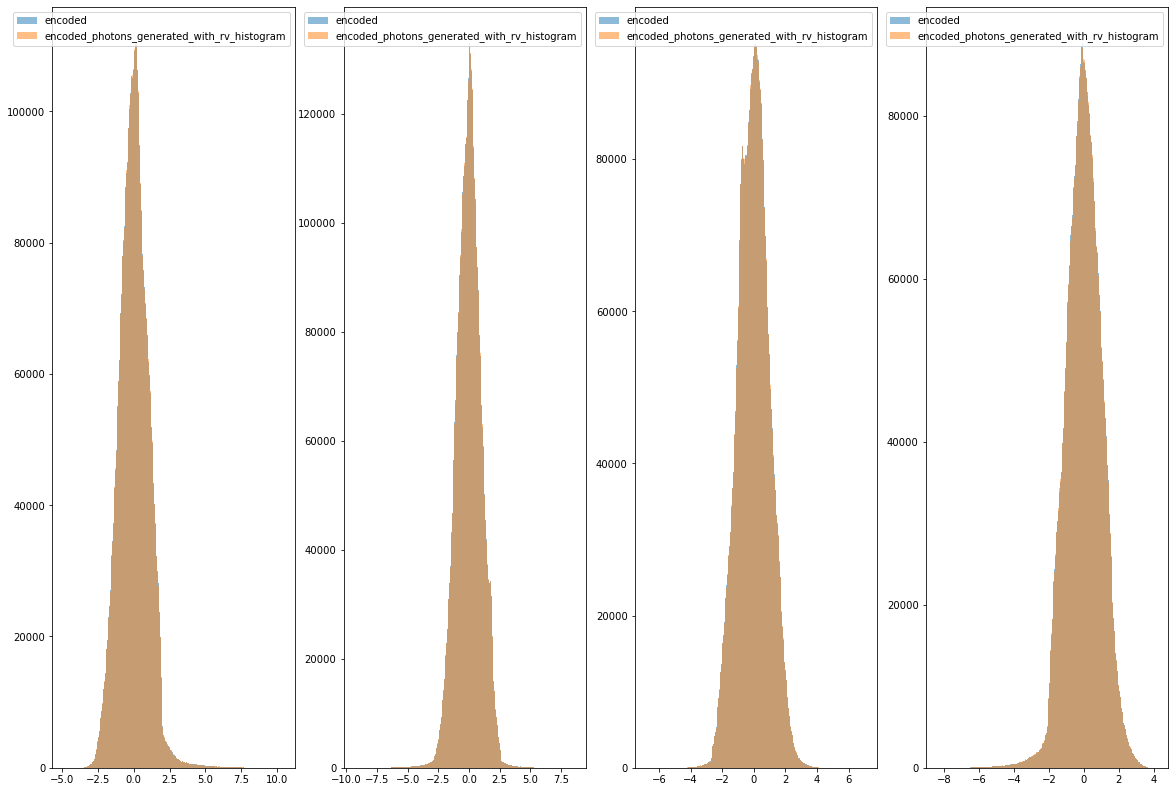

In [ ]:
fig, axs = plt.subplots(NUM_SUBPLOT_ROWS, NUM_SUBPLOT_COLUMNS)
fig.set_size_inches(20, 14)
for i in range(LANTENT_SPACE_DIM):
    mi = np.minimum(encoded[:, i].min(), encoded_photons_generated_with_rv_histogram[:, i].min())
    ma = np.maximum(encoded[:, i].max(), encoded_photons_generated_with_rv_histogram[:, i].max())
    bins = np.linspace(mi, ma, 300)
    axs.flatten()[i].hist(encoded[:, i], bins, alpha=.5, label='encoded')
    axs.flatten()[i].hist(encoded_photons_generated_with_rv_histogram[:, i], bins, alpha=.5, label='encoded_photons_generated_with_rv_histogram')
    axs.flatten()[i].legend()

In [ ]:
encoded_photons_generated_with_rv_histogram_dataset=PhotonsDataset(data=encoded_photons_generated_with_rv_histogram, transform=ToTensorFromNdarray())
encoded_photons_generated_with_rv_histogram_dataloader=DataLoader(dataset=encoded_photons_generated_with_rv_histogram_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

In [ ]:
decoded_photons_generated_with_rv_histogram_=np.empty((0,6))
model.eval()
with torch.no_grad():
    for encoded_photons_generated_with_rv_histogram_batch in encoded_photons_generated_with_rv_histogram_dataloader:

        # Decode pca_encode_batch
        decoded_photons_generated_with_rv_histogram_batch = model.decoder(encoded_photons_generated_with_rv_histogram_batch.float())

        decoded_photons_generated_with_rv_histogram_batch=decoded_photons_generated_with_rv_histogram_batch.cpu().detach().numpy()
        
        # Standarizer inverse transform
        decoded_photons_generated_with_rv_histogram_batch=dm.stdcs.inverse_transform(decoded_photons_generated_with_rv_histogram_batch)

        # Prepare numpy arrays
        decoded_photons_generated_with_rv_histogram_ = np.append(decoded_photons_generated_with_rv_histogram_, decoded_photons_generated_with_rv_histogram_batch, axis=0)

        print(decoded_photons_generated_with_rv_histogram_.shape)

(300000, 6)
(600000, 6)
(900000, 6)
(1200000, 6)
(1500000, 6)
(1800000, 6)
(2100000, 6)
(2400000, 6)
(2700000, 6)
(3000000, 6)
(3300000, 6)
(3600000, 6)
(3900000, 6)
(4200000, 6)
(4500000, 6)
(4800000, 6)
(5087614, 6)


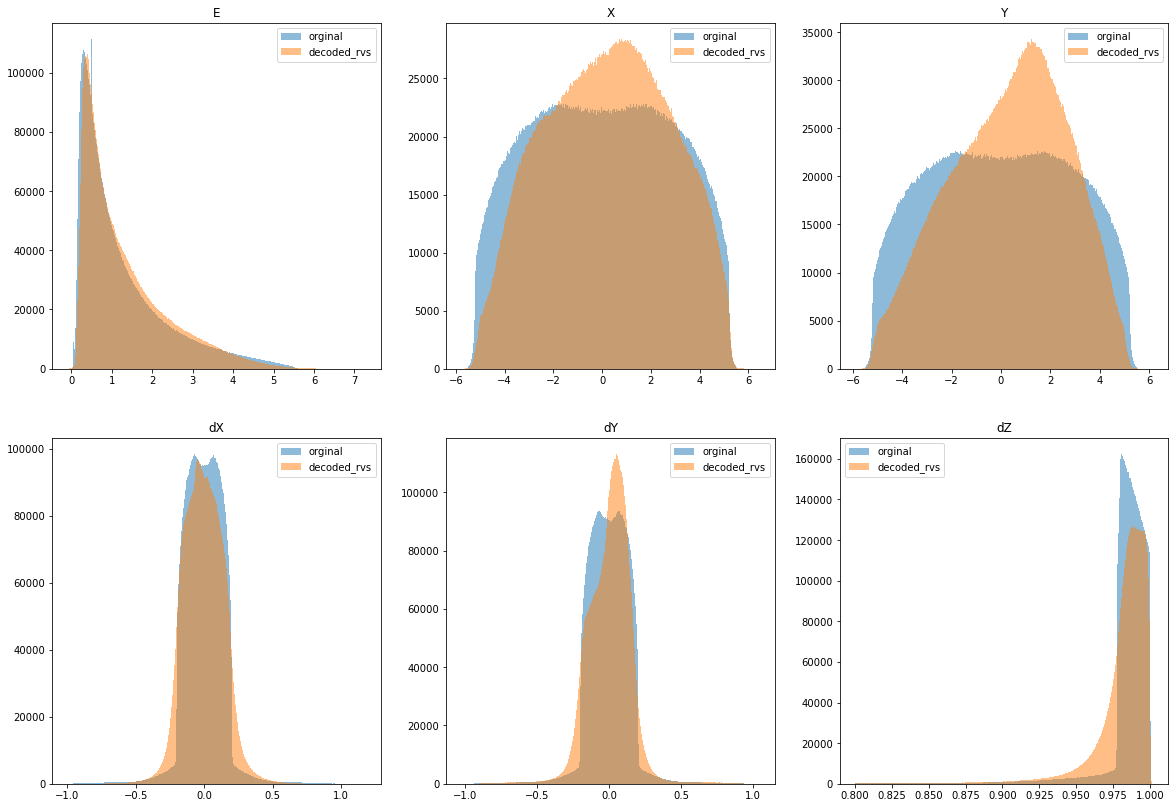

In [ ]:
fig, axs = plt.subplots(2, 3)
fig.set_size_inches(20, 14)
for i, j in enumerate(keys):
    mi = np.minimum(orginal_photons[:, i].min(), decoded_photons_generated_with_rv_histogram_[:, i].min())
    ma = np.maximum(orginal_photons[:, i].max(), decoded_photons_generated_with_rv_histogram_[:, i].max())
    if j=='dZ':
        mi=0.8
    bins = np.linspace(mi, ma, 300)
    axs.flatten()[i].hist(orginal_photons[:, i], bins, alpha=.5, label='orginal')
    axs.flatten()[i].hist(decoded_photons_generated_with_rv_histogram_[:, i], bins, alpha=.5, label='decoded_rvs')
    axs.flatten()[i].set_title(j)
    axs.flatten()[i].legend()